In [94]:
import pandas as pd
import pickle
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import pystan
import random
from sklearn.neighbors import KernelDensity
from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal, gaussian_kde, entropy, gamma
from fastkde import fastKDE
from entropy_estimators import continuous
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns


# Helper functions    

In [77]:
def KLdivergence(x, y):
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)

    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
    thresh = 1e-4
    r = xtree.query(x, k=100, eps=.01, p=2)[0]
    r = r[np.arange(r.shape[0]), np.argmax(r > thresh, axis=1)] 
    s = ytree.query(x, k=100, eps=.01, p=2)[0]
    s = s[np.arange(s.shape[0]), np.argmax(s > thresh, axis=1)]
    
    if math.isinf(-np.log(r/s).sum() * d / n + np.log(m / (n - 1.))):
        a = 0;

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

def kl_mvn(m0, S0, m1, S1):
 
  # store inv diag covariance of S1 and diff between means
  N = m0.shape[0]
  iS1 = np.linalg.inv(S1)
  diff = m1 - m0

  # kl is made of three terms
  tr_term   = np.trace(iS1 @ S0)
  det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
  quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
  #print(tr_term,det_term,quad_term)
  return .5 * (tr_term + det_term + quad_term - N) 

def surprisal(dist, sample):
    kde = gaussian_kde(dist)
    prob = kde.evaluate(sample)
    return -np.log(prob)
  

Build model

In [78]:
# whether to recompile the stan program
DO_COMPILE = False

# simple noise or prior on noise
SIMPLE_NOISE = True

# stan program path
if SIMPLE_NOISE:
    stan_path = 'multi_feature_simple_noise.stan'
    pkl_file = 'model_simple_noise.pkl'
else:
    stan_path = 'multi_feature.stan'
    pkl_file = 'model.pkl'


def build_model(path, pkl_file=None, do_compile=True):
    if do_compile:
        sm = pystan.StanModel(file=path)
        if pkl_file is not None:
            with open(pkl_file, 'wb') as f:
                pickle.dump(sm, f)

    # if the program hasn't been complied, check that the file already exists
    else: 
        if os.path.isfile(pkl_file):
            sm = pickle.load(open(pkl_file, 'rb'))
        else:
            raise FileNotFoundError
    return sm


sm = build_model(path = stan_path, pkl_file='model_simple_noise.pkl', do_compile=DO_COMPILE)

Model parameters

In [130]:
# mu
mu_mean = 0
mu_sd = 0.5

# sd
sigma_alpha = 2
sigma_beta = 2


# lower bound of sigma prior
lower_sigma_bound = 0.1

# noise SD prior
epsilon_alpha = 1
epsilon_beta = 1

# for simple noise 
noise = 0.1

# environmental EIG
env_info = 0.02

Create data

In [132]:

# number of stimuli
sequence_length = 6

# number of features 
num_features = 1

# number of samples (max)
num_samples = 3000

# allocation of samples to exemplars
exemplar_idx = np.repeat(np.arange(1, sequence_length+1), num_samples/sequence_length)

# background / deviant mean values
background = np.repeat(1, num_features)
deviant = np.repeat(3, num_features)

# perceptual noise
sig = np.identity(num_features) * 0.1;

# deviant position
deviant_pos = 6

# stimulus means
exemplar_means = np.tile(background, (sequence_length, 1))
exemplar_means[deviant_pos-1] = deviant

Simulation parameters

In [133]:
# number of iterations and warmup per model run
num_iter = 20000
num_warmup = 1000

# number of total model runs
num_model_runs = 3

# how much to thin posteriors (value determines how we "retain every nth sample")
thinning_factor = 1



Initialize flags, variables, iterators 

In [134]:
# Flags 
sample = True
policy = 'kl' # 'kl', 'surprisal', 'entropy' or 'eig'

# Variables
model_LT = np.zeros((num_model_runs, sequence_length))

# prior parameters
prior_mu = np.random.multivariate_normal(np.repeat(mu_mean, num_features), np.identity(num_features)*mu_sd, num_iter-num_warmup)

prior_sigma = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_features):
    
    # compute truncated sigma prior
    nrm=gamma.cdf(100, a = sigma_alpha, scale = 1/sigma_beta)- gamma.cdf(lower_sigma_bound, a = sigma_alpha, scale = 1/sigma_beta)
    yr=np.random.rand(num_iter-num_warmup)*(nrm)+gamma.cdf(lower_sigma_bound,  a = sigma_alpha, scale = 1/sigma_beta)
    prior_sigma[:,i] = gamma.ppf(yr, a = sigma_alpha, scale = 1/sigma_beta)
    
    
prior_z_rep = np.empty((num_iter-num_warmup, num_features))
for i in np.arange(0, num_iter-num_warmup):
    prior_z_rep[i,:] = np.random.multivariate_normal(prior_mu[i,:], np.identity(num_features)*prior_sigma[i,:])

prior = np.hstack((prior_mu[0:len(prior_mu):thinning_factor], prior_sigma[0:len(prior_sigma):thinning_factor]))

data = {"mu_mean": mu_mean , "mu_sd": mu_sd, "sigma_alpha": sigma_alpha, "sigma_beta": sigma_beta, 
"epsilon_alpha": epsilon_alpha, "epsilon_beta": epsilon_beta, "noise": noise, "F": num_features}

stim_info = np.empty((num_model_runs, num_samples))
stim_info[:] = np.nan

# Action loop


Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.021706 seconds (Warm-up)
               0.448071 seconds (Sampling)
               0.469777 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.027846 seconds (Warm-up)
               0.310463 seconds (Sampling)
               0.338309 seconds (Total)




Gradient evaluation took 9e-06 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.030346 seconds (Warm-up)
               0.504615 seconds (Sampling)
               0.534961 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.044095 seconds (Warm-up)
               0.617099 seconds (Sampling)
               0.661194 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.041645 seconds (Warm-up)
               0.976371 seconds (Sampling)
               1.01802 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.033947 seconds (Warm-up)
               0.611888 seconds (Sampling)
               0.645835 seconds (Total)


Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'multi_feature_simple_noise.stan' at line 36)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.035908 seconds (Warm-up)
               0.559879 seconds (Sampling)
               0.595787 seconds (Total)




Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.037658 seconds (Warm-up)
               0.587424 seconds (Sampling)
               0.625082 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.044529 seconds (Warm-up)
               0.670994 seconds (Sampling)
               0.715523 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.040771 seconds (Warm-up)
               0.675189 seconds (Sampling)
               0.71596 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.023801 seconds (Warm-up)
               0.397246 seconds (Sampling)
               0.421047 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.024239 seconds (Warm-up)
               0.423557 seconds (Sampling)
               0.447796 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.037117 seconds (Warm-up)
               1.01742 seconds (Sampling)
               1.05454 seconds (Total)




Gradient evaluation took 1.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.049027 seconds (Warm-up)
               0.742031 seconds (Sampling)
               0.791058 seconds (Total)




Gradient evaluation took 1.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.039097 seconds (Warm-up)
               0.558441 seconds (Sampling)
               0.597538 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.042296 seconds (Warm-up)
               0.65893 seconds (Sampling)
               0.701226 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.038143 seconds (Warm-up)
               0.515378 seconds (Sampling)
               0.553521 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.043049 seconds (Warm-up)
               0.578757 seconds (Sampling)
               0.621806 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.045987 seconds (Warm-up)
               0.779964 seconds (Sampling)
               0.825951 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.045756 seconds (Warm-up)
               0.672577 seconds (Sampling)
               0.718333 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.051091 seconds (Warm-up)
               0.706477 seconds (Sampling)
               0.757568 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.020872 seconds (Warm-up)
               0.300361 seconds (Sampling)
               0.321233 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.024279 seconds (Warm-up)
               0.370033 seconds (Sampling)
               0.394312 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.02447 seconds (Warm-up)
               0.439822 seconds (Sampling)
               0.464292 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.029638 seconds (Warm-up)
               0.402747 seconds (Sampling)
               0.432385 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.035079 seconds (Warm-up)
               0.590933 seconds (Sampling)
               0.626012 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.051887 seconds (Warm-up)
               0.715591 seconds (Sampling)
               0.767478 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.038354 seconds (Warm-up)
               0.565622 seconds (Sampling)
               0.603976 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.043116 seconds (Warm-up)
               0.794629 seconds (Sampling)
               0.837745 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.050466 seconds (Warm-up)
               0.900508 seconds (Sampling)
               0.950974 seconds (Total)




Gradient evaluation took 1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.051511 seconds (Warm-up)
               0.73281 seconds (Sampling)
               0.784321 seconds (Total)




Gradient evaluation took 1.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 20000 [  0%]  (Warmup)
Iteration:  1001 / 20000 [  5%]  (Sampling)
Iteration:  3000 / 20000 [ 15%]  (Sampling)
Iteration:  5000 / 20000 [ 25%]  (Sampling)
Iteration:  7000 / 20000 [ 35%]  (Sampling)
Iteration:  9000 / 20000 [ 45%]  (Sampling)
Iteration: 11000 / 20000 [ 55%]  (Sampling)
Iteration: 13000 / 20000 [ 65%]  (Sampling)
Iteration: 15000 / 20000 [ 75%]  (Sampling)
Iteration: 17000 / 20000 [ 85%]  (Sampling)
Iteration: 19000 / 20000 [ 95%]  (Sampling)
Iteration: 20000 / 20000 [100%]  (Sampling)

 Elapsed Time: 0.073955 seconds (Warm-up)
               1.16334 seconds (Sampling)
               1.23729 seconds (Total)



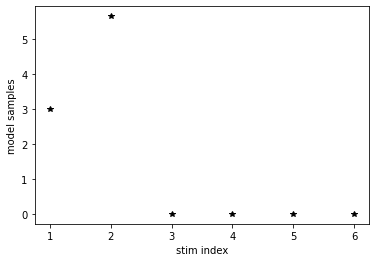

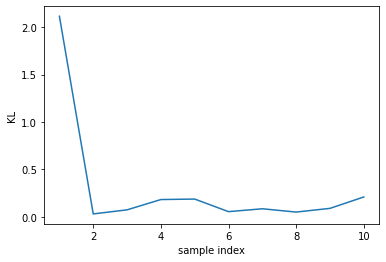

In [91]:
for run in np.arange(0, num_model_runs):

    # generate the data
    sim_data = [np.random.multivariate_normal(exemplar_means[idx-1], sig) for idx in exemplar_idx] 
    sim_data = np.asmatrix(sim_data)

    # Iterators
    samples_from_current_stim = 1
    total_samples = 1
    exemplar_num = 1

    # initialize data
    sample_data = np.empty((num_samples,num_features))
    sample_data[:] = np.nan

    exemplar_labels = np.empty((num_samples,))
    exemplar_labels[:] = np.nan

    while sample or samples_from_current_stim > 1:
        
        # sample number
        data["M"] = total_samples

        # exemplar number 
        data["K"] = exemplar_num

        # add sim data
        sample_data[total_samples-1] = sim_data[exemplar_idx == exemplar_num][samples_from_current_stim-1]
        data["z"] = np.transpose(sample_data[0:total_samples,:])

        # add exemplar for each id
        exemplar_labels[total_samples-1] = int(exemplar_num)
        data["exemplar_idx"] = [int(x) for x in exemplar_labels[~np.isnan(exemplar_labels)]]

        # get posterior samples
        fit = sm.sampling(data=data, iter=num_iter, chains=1, warmup = num_warmup,control=dict(adapt_delta=0.95));
        
        
        posterior = np.hstack((fit['mu'][0:len(fit['mu']):thinning_factor], \
                               fit['sigma'][0:len(fit['mu']):thinning_factor]))
        
        if policy is 'kl':

            if total_samples > 10:
                break;
                a = 0;
            
            # KL divergence between prior and posterior
            stim_info[run, total_samples-1] = KLdivergence(prior, posterior)

        elif policy is 'entropy':
            # reduction of entropy
            stim_info[run,total_samples-1] = entropy(prior) - entropy(posterior)

        elif policy is 'surprisal':

            # surprisal of current observation given prior
            stim_info[run, total_samples-1] = surprisal(prior[:,2], sample_data[total_samples-1])

        elif policy is 'EIG':
            stim_info[run,total_samples-1] = EIG(posterior)

        # decision rule
        if stim_info[run,total_samples-1] < env_info:
            model_LT[run, exemplar_num-1] = samples_from_current_stim

            # reset/increment counters
            samples_from_current_stim = 1
            exemplar_num += 1

            if exemplar_num > sequence_length:
                sample = False

        else:
            samples_from_current_stim += 1 

        if policy is 'kl' or policy is 'surprisal' or policy is 'entropy':
            prior = posterior
        
        total_samples += 1

    # start sampling for next model run
    sample = True


plt.plot(np.arange(1,sequence_length+1), np.mean(model_LT, axis = 0).squeeze(), 'k*')

plt.xlabel("stim index")
plt.ylabel("model samples")
plt.title("")
plt.show()


plt.plot(np.arange(1,total_samples+1),np.mean(stim_info, axis = 0)[0:total_samples].squeeze())

plt.xlabel("sample index")
plt.ylabel("KL")
plt.title("")
plt.show()

In [92]:
print("KL")
print(KLdivergence(prior[:,[0]], posterior[:,[0]]))
print(kl_mvn(mean_prior, sd_prior, mean_posterior, sd_posterior))

mean_prior = np.array([np.mean(prior[:,[0]], axis = 0)])

sd_prior = np.array([np.std(prior[:,[0]], axis = 0)])

mean_posterior = np.array([np.mean(posterior[:,[0]], axis = 0)])

sd_posterior = np.array([np.std(posterior[:,[0]], axis = 0)])


print("means")

print(mean_prior)
print(mean_posterior)

print("SD")
print(sd_prior)
print(sd_posterior)

print("data")
print(data['z'])


posterior.shape


KL
0.059316937903608244
[[0.14564623]]
means
[[0.81020168]]
[[0.86608738]]
SD
[[0.37619363]]
[[0.32102603]]
data
[[1.44832529 0.91365576 0.70754327 0.89208104 0.82955166 1.3488273
  1.60358576 0.55629275 1.0853994  1.35581186 0.95316086]]


(19000, 2)

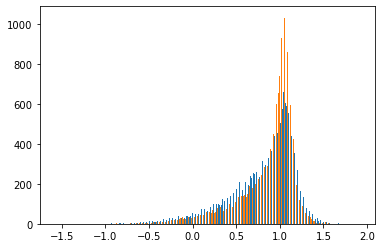

In [93]:
plt.hist(np.hstack((prior[:,[0]],posterior[:,[0]])), bins = 200);



array([0.10010844])

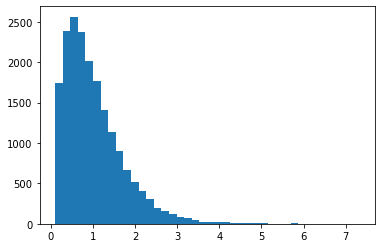

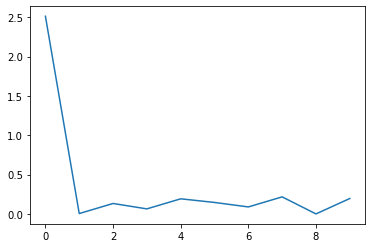

In [118]:
plt.plot(np.arange(0, stim_info.shape[1]), np.mean(stim_info, axis = 0))
plt.show()

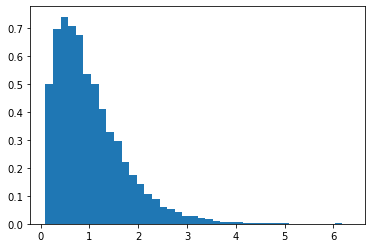

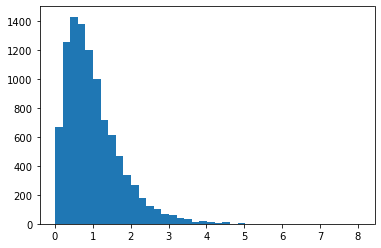

In [128]:

plt.hist(xr,density=True, bins = 40)
plt.show()
dist = gamma(a = 2, scale = 1/2)
plt.hist(dist.rvs(10000), bins = 40)
plt.show()


In [120]:
model_LT

array([[2., 2., 2., 3., 0., 0.],
       [2., 3., 4., 0., 0., 0.],
       [4., 3., 2., 0., 0., 0.]])

In [106]:
stim_info[1,0:20]

array([ 2.01619232,  0.00371586,  0.18321453,  0.19169076, -0.01187171,
        0.30167573,  0.0515528 ,  0.14896336, -0.01617405,  0.23803791,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [88]:
total_samples

21

In [107]:
exemplar_num
exemplar_labels

array([ 1.,  1.,  1., ..., nan, nan, nan])

In [113]:
stim_info.shape

(3, 3000)

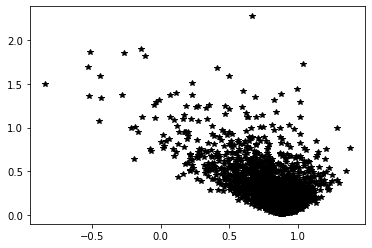

In [127]:
plt.plot(fit['mu'][0:len(fit['mu']):thinning_factor], fit['sigma'][0:len(fit['mu']):thinning_factor], 'k*')
plt.show()

(array([151., 418., 580., 683., 746., 822., 875., 918., 918., 878., 858.,
        851., 764., 730., 696., 676., 641., 600., 563., 504., 453., 389.,
        391., 322., 353., 293., 257., 244., 250., 211., 203., 171., 164.,
        133., 135., 118., 109.,  96.,  77.,  73.,  79.,  66.,  64.,  45.,
         44.,  36.,  35.,  37.,  32.,  34.,  24.,  17.,  28.,  11.,  19.,
          9.,  12.,  10.,   9.,   8.,   1.,   7.,   4.,   7.,   4.,   4.,
          4.,   3.,   2.,   3.,   1.,   3.,   4.,   2.,   2.,   1.,   1.,
          0.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,
          1.]),
 array([1.60952816e-02, 2.73371299e-01, 5.30647317e-01, 7.87923335e-01,
        1.04519935e+00, 1.30247537e+00, 1.55975139e+00, 1.81702741e+00,
        2.07430342e+00, 2.33157944e+00, 2.58885546e+00, 2.84613148e+00,
        3.10340750e+00, 3.36068351e+00, 3.61795953e+00, 3.87523555e+00,
        4.13251157e+00, 4.3897

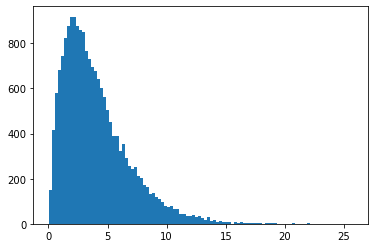

In [129]:
plt.hist(prior_sigma, bins = 100)